In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shuvoalok/raf-db-dataset
!unzip -q raf-db-dataset.zip
!ls DATASET/

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

# from mtcnn import MTCNN
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import random
seed = random.randint(1, 1000)
print(seed)

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset
License(s): other
  0% 0.00/37.7M [00:00<?, ?B/s]
100% 37.7M/37.7M [00:00<00:00, 962MB/s]
test  train
869


In [ ]:
img_size = 100 #original size of the image
targetx = img_size
targety = img_size

epochs = 100
batch_size = 64

train_dir = "DATASET/train"
test_dir = "DATASET/test"

"""
Applying data augmentation to the images
"""

train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.5
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,

)
val_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="training"

)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    subset="validation",
        seed=seed
)

Found 12271 images belonging to 7 classes.
Found 1535 images belonging to 7 classes.
Found 1533 images belonging to 7 classes.


In [ ]:
model= tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(targetx, targety, 3))) # đầu vào là ảnh RGB kích thước (100, 100, 3)
# Ảnh → Resize + Augmentation → CNN Blocks → Flatten → FC Layers → Softmax → Class

# Block 1: 2 lớp Conv2D với 32 và 64 filters. Sau đó chuẩn hóa và giảm chiều bằng MaxPooling.
# Conv2D(32) → Conv2D(64) → BatchNorm → MaxPooling → Dropout
# Học các đặc trưng cơ bản như cạnh, góc.
# Kích thước nhỏ, depth còn thấp → hoạt động như các bộ lọc đơn giản.
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2: Sử dụng kernel lớn hơn (5x5) để tăng receptive field.
# Conv2D(128, kernel_size=5x5) → BatchNorm → MaxPooling → Dropout
# Kernel lớn hơn → receptive field rộng hơn → học được đặc trưng phức tạp hơn (vật thể, hoa văn...).
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3 & 4: Dùng regularization L2 để chống overfitting. Tăng số filters lên 512 → trích xuất đặc trưng sâu hơn.
# Conv2D(512) + L2 regularization → BatchNorm → MaxPooling → Dropout
# Độ sâu lớn hơn → học đặc trưng trừu tượng, có tính khái quát cao.
# L2 giúp hạn chế mô hình "nhớ quá kỹ" (overfitting).
# BatchNorm ổn định và tăng tốc quá trình huấn luyện.
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Mục tiêu các block CNN: từ đặc trưng cục bộ đơn giản → trích xuất đặc trưng toàn cục phức tạp hơn.

# Tầng phân loại Fully Connected (FC) layers:
# Flatten → Dense(256) → Dense(512) → Dense(7, softmax)
# Flatten: biến ảnh thành vector để đưa vào FC.
# Dense(256) → Dense(512): học quan hệ giữa đặc trưng và class, hoạt động như một “bộ suy luận”.
# softmax: xuất xác suất thuộc về mỗi lớp (7 lớp).
# Mục tiêu: đưa ra dự đoán xác suất cho mỗi lớp từ đặc trưng đã học.
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

# Compile mô hình:
# Adam: tối ưu hóa hiệu quả.
# categorical_crossentropy: phù hợp với phân loại đa lớp (với nhãn one-hot).
# accuracy: để đo lường hiệu suất.

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,036,423 (30.66 MB)

 Trainable params: 8,032,455 (30.64 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '':
    print(f' GPU đã sẵn sàng: {device_name}')
else:
    print(' Không tìm thấy GPU. Hãy kiểm tra lại trong Runtime > Change runtime type.')

history = model.fit(x = train_generator,epochs = epochs,validation_data = val_generator)


 GPU đã sẵn sàng: /device:GPU:0


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 75s 223ms/step - accuracy: 0.2924 - loss: 9.3469 - val_accuracy: 0.3863 - val_loss: 8.9400
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.4830 - loss: 8.2342 - val_accuracy: 0.4000 - val_loss: 8.7369
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.5495 - loss: 7.4815 - val_accuracy: 0.5668 - val_loss: 7.0524
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.5999 - loss: 6.7981 - val_accuracy: 0.6339 - val_loss: 6.1935
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 112ms/step - accuracy: 0.6321 - loss: 6.1400 - val_accuracy: 0.6508 - val_loss: 5.6721
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.6572 - loss: 5.5568 - val_accuracy: 0.6586 - val_loss: 5.2052
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.6846 - loss: 5.0092 - val_accuracy: 0.7062 - val_loss: 4.6179
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.7085 -

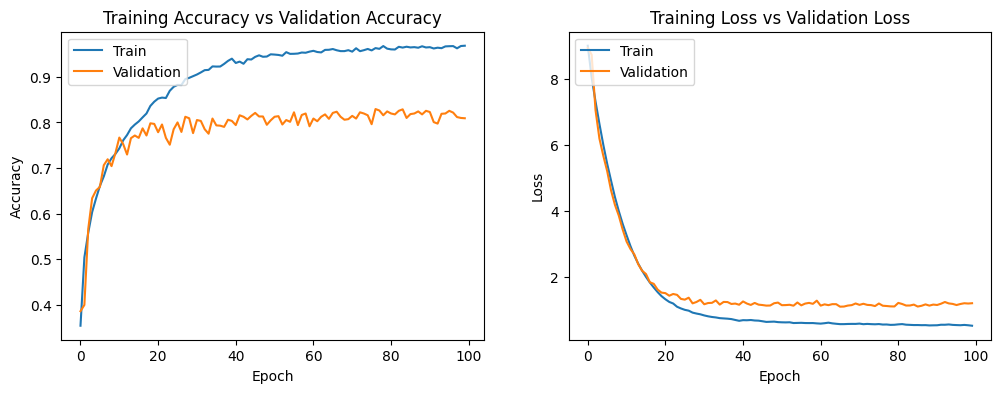

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.save('model_optimal.h5')
from google.colab import files
files.download('model_optimal.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.76      0.79       164
           2       0.57      0.22      0.31        37
           3       0.72      0.51      0.60        80
           4       0.93      0.94      0.93       592
           5       0.81      0.78      0.79       239
           6       0.82      0.62      0.70        81
           7       0.75      0.91      0.82       340

    accuracy                           0.83      1533
   macro avg       0.77      0.68      0.71      1533
weighted avg       0.83      0.83      0.83      1533



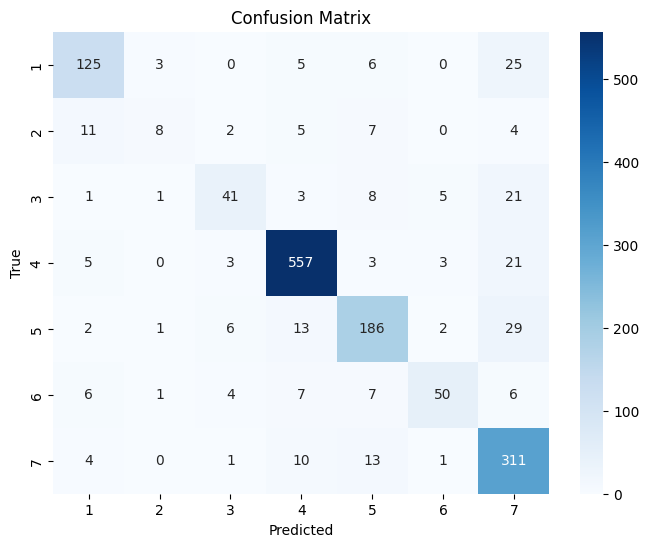

In [ ]:
# MA TRẬN NHẦM LẪN VÀ CÁC CHỈ SỐ ĐÁNH GIÁ
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

(100, 100, 3)


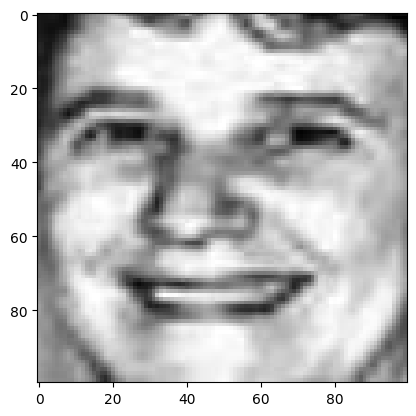

In [ ]:
import keras.utils as image
img = image.load_img("DATASET/test/4/test_0041_aligned.jpg",target_size = (targetx,targety,3))
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

label_dict = {0:'SURPRISED',1:'FEARFUL',2:'DISGUSTED',3:'HAPPY',4:'SAD',5:'ANGRY',6:'NEUTRAL'}


In [ ]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,targetx,targety,3)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(1.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)]


In [ ]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

HAPPY


In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc   = model.evaluate(val_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, val_acc*100))

192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.9923 - loss: 0.4509
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7978 - loss: 1.2904
final train accuracy = 99.23 , validation accuracy = 80.91


In [ ]:
test_loss, test_acc   = model.evaluate(test_generator)
print("final test accuracy = {:.2f}".format(test_acc*100))

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7807 - loss: 1.5016
final test accuracy = 83.37


In [ ]:
model.save_weights('model.weights.h5')